## TUTORIAL 06 - Unsteady Thermal block problem
**_Keywords: POD-Galerkin method, scalar problem_**

### 1. Introduction
In this Tutorial, we consider unsteady heat conduction in a two-dimensional domain $\Omega$.

![mesh](data/mesh.png)

We define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk centered at the origin of radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$. 

The conductivity $\kappa$ is assumed to be constant on $\Omega_1$ and $\Omega_2$, i.e.
$$
\kappa|_{\Omega_1}=\kappa_0 \quad \textrm{and} \quad \kappa|_{\Omega_2}=1.
$$

For this problem, we consider $P=2$ parameters:
1. the first one is related to the conductivity in $\Omega_1$, i.e. $\mu_0\equiv\kappa_0$ (_note that parameters numbering is zero-based_);
2. the second parameter $\mu_1$ takes into account the constant heat flux over $\Gamma_{base}$.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.1,10]\times[-1,1].
$$

In this problem we model the heat transfer process due to the heat flux over the bottom boundary $\Gamma_{base}$ and the following conditions on the remaining boundaries:
* the left and right boundaries $\Gamma_{side}$ are insulated,
* the top boundary $\Gamma_{top}$ is kept at a reference temperature (say, zero),

with the aim of measuring the average temperature on $\Gamma_{base}$.

In order to obtain a faster approximation of the problem we pursue a model reduction by means of a POD-Galerkin reduced order method.

### 2. Parametrized formulation

Let $u(t;\boldsymbol{\mu})$ be the temperature in the domain $\Omega\times[0,t_f]$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, for $t\in[0,t_f]$, find $u(t;\boldsymbol{\mu})$ such that

$$
\begin{cases}
	\partial_tu(t;\boldsymbol{\mu})- \text{div} (\kappa(\mu_0)\nabla u(t;\boldsymbol{\mu})) = 0 & \text{in } \Omega\times[0,t_f],\\
    u(t=0;\boldsymbol{\mu}) = 0 & \text{in } \Omega, \\ 
	u(t;\boldsymbol{\mu}) = 0 & \text{on } \Gamma_{top}\times[0,t_f],\\
	\kappa(\mu_0)\nabla u(t;\boldsymbol{\mu})\cdot \mathbf{n} = 0 & \text{on } \Gamma_{side}\times[0,t_f],\\
	\kappa(\mu_0)\nabla u(t;\boldsymbol{\mu})\cdot \mathbf{n} = \mu_1 & \text{on } \Gamma_{base}\times[0,t_f].
\end{cases}
$$
<br>

where 
* $\mathbf{n}$ denotes the outer normal to the boundaries $\Gamma_{side}$ and $\Gamma_{base}$,
* the conductivity $\kappa(\mu_0)$ is defined as follows:
$$
\kappa(\mu_0) =
\begin{cases}
	\mu_0 & \text{in } \Omega_1,\\
	1 & \text{in } \Omega_2,\\
\end{cases}
$$

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, for $t\in[0,t_f]$, find $u(t;\boldsymbol{\mu})\in\mathbb{V}$ such that

$$m\left(\partial_tu(t;\boldsymbol{\mu}),v;\boldsymbol{\mu}\right) + a\left(u(t;\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V},\quad \forall t\in[0,t_f]$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H^1(\Omega) : v|_{\Gamma_{top}}=0\}
$$
* the parametrized bilinear form $m(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$m(u, v;\boldsymbol{\mu})=\int_{\Omega} \partial_tu(t)v \ d\boldsymbol{x},$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \kappa(\mu_0)\nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \mu_1\int_{\Gamma_{base}}v \ ds,$$

The (compliant) output of interest $s(t;\boldsymbol{\mu})$ is given by
$$s(t;\boldsymbol{\mu}) = \mu_1\int_{\Gamma_{base}} u(t;\boldsymbol{\mu})$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:
$$m(u,v;\boldsymbol{\mu})=\underbrace{1}_{\Theta^{m}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}uv \ d\boldsymbol{x}}_{m_0(u,v)},$$
$$a(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega_1}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega_2}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{\mu_1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{base}}v \ ds}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class UnsteadyThermalBlock(ParabolicCoerciveProblem):
```
by specifying the coefficients $\Theta^{m}_*(\boldsymbol{\mu})$, $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $m_*(u, v)$, $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
class UnsteadyThermalBlock(ParabolicCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        ParabolicCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    # Return custom problem name
    def name(self):
        return "UnsteadyThermalBlock1POD"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "m":
            theta_m0 = 1.
            return (theta_m0, )
        elif term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = mu[1]
            return (theta_f0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "m":
            u = self.u
            m0 = u * v * dx
            return (m0, )
        elif term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx(1)
            a1 = inner(grad(u), grad(v)) * dx(2)
            return (a0, a1)
        elif term == "f":
            ds = self.ds
            f0 = v * ds(1)
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        elif term == "projection_inner_product":
            u = self.u
            x0 = u * v * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/thermal_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/thermal_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/thermal_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1, two components)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the UnsteadyThermalBlock class

In [5]:
problem = UnsteadyThermalBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)
problem.set_time_step_size(0.05)
problem.set_final_time(3)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20, nested_POD=5)
reduction_method.set_tolerance(1e-8, nested_POD=1e-6)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

=          UnsteadyThermalBlock1POD POD-Galerkin offline phase begins          =

###################################### 0 #######################################
truth solve for mu = (5.533253688880515, 0.43037873274483895)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
update snapshots matrix
lambda_0 = 17.446535852154224
lambda_1 = 0.4767477373939005
lambda_2 

# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
update snapshots matrix
lambda_0 = 62.39285063725052
lambda_1 = 1.7971645495149353
lambda_2 = 0.07942722084828735
lambda_3 = 0.004079998053413933
lambda_4 = 0.00019483819365512798

###################################### 9 #######################################
truth solve for mu = (7.80375183440352, 0.74002429649363

# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
update snapshots matrix
lambda_0 = 1.7645257008366662
lambda_1 = 0.04877681700981471
lambda_2 = 0.0014805710493965146
lambda_3 = 4.4771264474429575e-05

###################################### 17 ######################################
truth solve for mu = (0.2860190243199159, 0.23527099415175412)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6


update snapshots matrix
lambda_0 = 7.0457487334361275
lambda_1 = 0.19899851965879123
lambda_2 = 0.006117039158302101
lambda_3 = 0.00019433280227141843

###################################### 25 ######################################
truth solve for mu = (5.744948027137008, -0.1227969730753593)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
update snapshots matrix

# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
update snapshots matrix
lambda_0 = 61.41185332868945
lambda_1 = 1.6375833682412397
lambda_2 = 0.049265043429304704
lambda_3 = 0.001429409456531243

###################################### 34 ######################################
truth solve for mu = (8.395654584238159, -0.8078031842120739)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 

# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
update snapshots matrix
lambda_0 = 17.133852394018586
lambda_1 = 0.49368039032275013
lambda_2 = 0.0170251798481041
lambda_3 = 0.000789809266478577
lambda_4 = 2.7217453532668917e-05

###################################### 42 ######################################
truth solve for mu = (5.709354396645094, -0.46922101812110917)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# 


###################################### 50 ######################################
truth solve for mu = (6.810383714282678, -0.4599840536156703)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
update snapshots matrix
lambda_0 = 19.96227801248086
lambda_1 = 0.538408248620004
lambda_2 = 0.016227129812907103
lambda_3 = 0.0004755669983861884

##########################

# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
update snapshots matrix
lambda_0 = 2.501557504353184
lambda_1 = 0.06643708807274702
lambda_2 = 0.0019977048320475553
lambda_3 = 5.778308317350836e-05

###################################### 59 ######################################
truth solve for mu = (8.829180082363042, 0.38506318015553176)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t

# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
update snapshots matrix
lambda_0 = 16.565832259576247
lambda_1 = 0.4805701515994384
lambda_2 = 0.01556826787025584
lambda_3 = 0.000605701926347424
lambda_4 = 1.7890220584051438e-05

###################################### 67 ######################################
truth solve for mu = (5.742652615942522, 0.18174552249634646)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t

# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
update snapshots matrix
lambda_0 = 54.465814792182876
lambda_1 = 1.5785060115847478
lambda_2 = 0.050768737264842455
lambda_3 = 0.0019218575101327547
lambda_4 = 5.647842035102715e-05

###################################### 76 ######################################
truth solve for mu = (1.7086800532961108, 0.2311191285

# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
update snapshots matrix
lambda_0 = 11.814373739258471
lambda_1 = 0.34766996595732164
lambda_2 = 0.01890043994584275
lambda_3 = 0.0010361624678680284
lambda_4 = 5.77449130903471e-05

###################################### 84 ######################################
truth solve for mu = (7.326906567998174, -0.656740645477119)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t =

lambda_0 = 25.89030812671184
lambda_1 = 0.7052571462859097
lambda_2 = 0.021303520341694686
lambda_3 = 0.0006310292637332803

###################################### 92 ######################################
truth solve for mu = (9.348718579455458, 0.22793191193179196)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
update snapshots matrix
lambda_0 = 4.9234100133872

lambda_5 = 0.09205980875423098
lambda_6 = 0.06779524281016376
lambda_7 = 0.011277854072012022
lambda_8 = 0.001762021240584707
lambda_9 = 0.0009488769117149331
lambda_10 = 0.0005008519019598801
lambda_11 = 9.148596762162335e-05
lambda_12 = 2.280209190462568e-05

build reduced operators

=           UnsteadyThermalBlock1POD POD-Galerkin offline phase ends           =



#### 4.5.2 Train PINN

Given a training set $\Xi_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(N_\text{PINN})})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $u^{NN}(\boldsymbol{\mu})$ for the reduced order equations dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(\Xi_{PINN}; W) = \\ \frac{1}{N_\text{PINN}} \sum_{i=1}^{N_\text{PINN}} \left\|M(\boldsymbol{\mu^{(i)}})\frac{\partial u^{NN}}{\partial t}(\boldsymbol{\mu^{(i)}}) + A(\boldsymbol{\mu^{(i)}}) u^{NN}(\boldsymbol{\mu}^{(i)}) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\right\|_{\ 2}^{\ 2}$$

over $W$, where for a given $\boldsymbol{\mu}$, $M(\boldsymbol{\mu})$ is the mass matrix corresponding to the bilinear form $m$, $A(\boldsymbol{\mu})$ is the assembled matrix corresponding to the bilinear form $a$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled vector corresponding to the linear form $f$. The partial derivative $\frac{\partial u^{NN}}{\partial t}(\boldsymbol{\mu^{(i)}})$ is computed via automatic differentiation in PyTorch.

In [8]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [9]:
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
pinn_trainer.optimizer = optimizer
pinn_trainer.train()

  0%|                                                                      | 0/10000 [00:00<?, ?it/s]

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...


/Users/pichi/opt/anaconda3/envs/mlnics/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
100%|██████████████████████████████████| 10000/10000 [08:37<00:00, 19.33it/s, Loss(training)=0.00271]


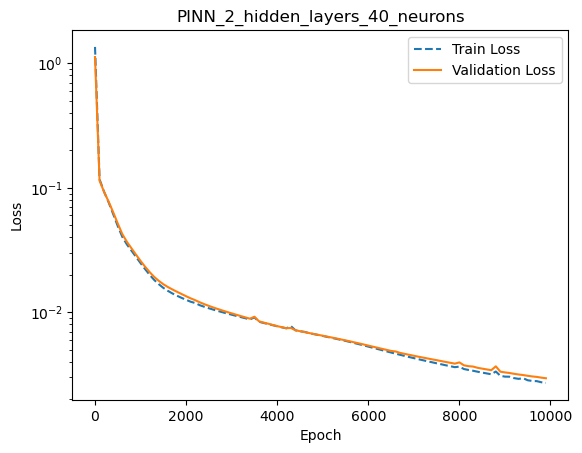

In [10]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $\Xi_{PDNN} = ((\boldsymbol{\mu}^{(1)}, u^{\text{HF}}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(N_\text{PDNN})}, u^{\text{HF}}(\boldsymbol{\mu}^{(N_\text{PDNN})})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $u^{NN}(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(\Xi_{PDNN}; W) = \frac{1}{N_\text{PDNN}} \sum_{i=1}^{N_\text{PDNN}} \|u^{NN}(\boldsymbol{\mu}^{(i)}; W) - U^T u^{\text{HF}}(\boldsymbol{\mu}^{(i)}; W)\|_2^2,$$
where for a given $\boldsymbol{\mu}$, the quantity $U^T u^{\text{HF}}(\boldsymbol{\mu})$ is the projection of  the high fidelity solution $u^{\text{HF}}(\boldsymbol{\mu})$ onto the reduced order solution space.

In [11]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [12]:
pdnn_trainer.train()

100%|█████████████████████████████████| 10000/10000 [00:33<00:00, 294.58it/s, Loss(training)=0.00325]


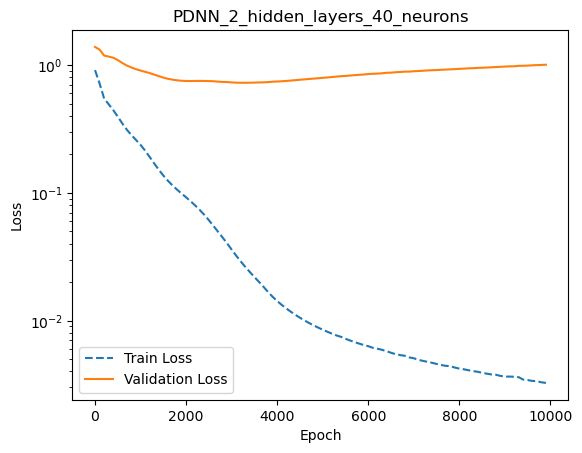

In [13]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $u^{NN}(\boldsymbol{\mu})$ dependnent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(\Xi_{PINN}, \Xi_{PDNN}; W) = L_{PINN}(\Xi_{PINN}; W) + \omega L_{PDNN}(\Xi_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [14]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [15]:
prnn_trainer.train()

  0%|                                                                      | 0/10000 [00:00<?, ?it/s]

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...


100%|████████████████████████████████████| 10000/10000 [07:55<00:00, 21.05it/s, Loss(training)=0.025]


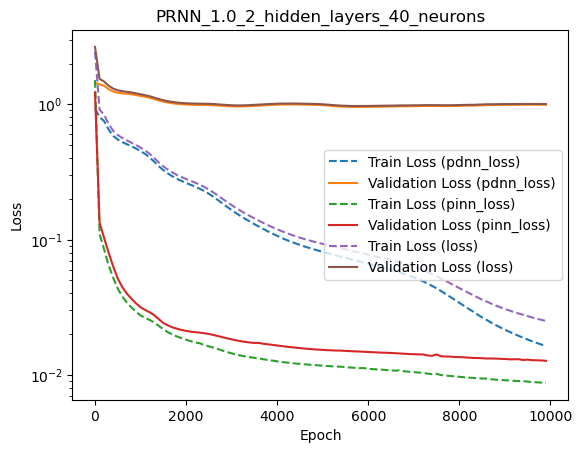

In [16]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [17]:
np.random.seed(0)

reduction_method.initialize_testing_set(100)
test_set_mu = torch.tensor(reduction_method.testing_set)
online_mu = tuple(np.array(reduction_method.testing_set)[0,:])

#### 4.6.2 PINN Error Analysis

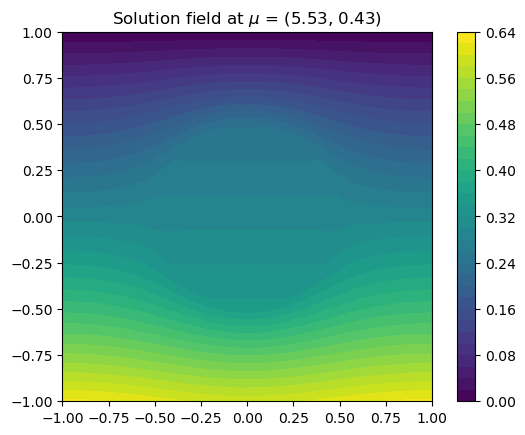

In [18]:
ErrorAnalysis.plot_solution(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)

In [19]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_set_mu, input_normalization_pinn, output_normalization_pinn, relative=False
)

# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t =

# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t =

# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t =

# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t =

# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t =

# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t =

# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t =

# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t =

# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t =

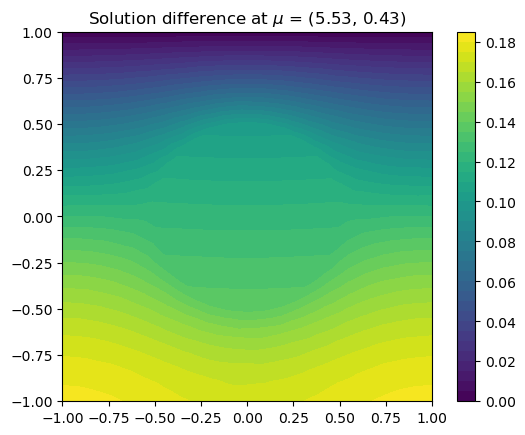

In [20]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, online_mu, input_normalization_pinn, output_normalization_pinn
)

#### 4.6.3 PDNN Error Analysis

In [21]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_set_mu, input_normalization_pdnn, output_normalization_pdnn, relative=False
)

################################# PDNN N = 13 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.000528161382573906	0.000528140195467339	0.0
mean	0.021778210996570572	0.02177790074939415	5.905808118821711e-05
max	0.3447460475260106	0.3447454044666766	0.0009222468479125397


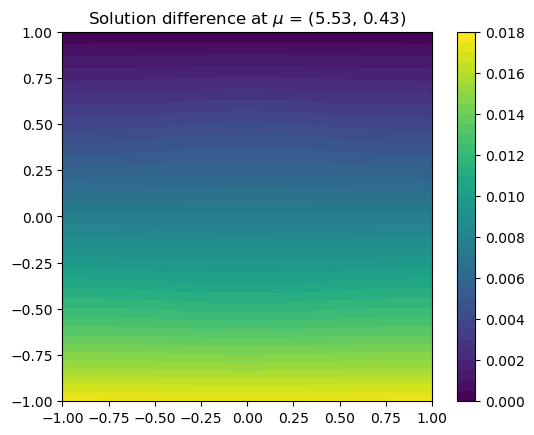

In [22]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, online_mu, input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [23]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_set_mu, input_normalization_prnn, output_normalization_prnn, relative=False
)

############################### PRNN_1.0 N = 13 ################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0008620117887970627	0.0008620117022312381	0.0
mean	0.05958800798558003	0.05958788538066915	5.905808118821711e-05
max	0.6097567749977647	0.6097567749977647	0.0009222468479125397


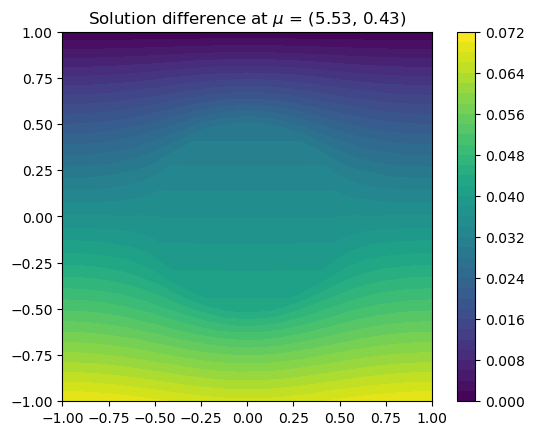

In [24]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, online_mu, input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [25]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_set_mu, input_normalizations, output_normalizations, relative=False
)

#####################################################################################
Mean Error for 13 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.25191676604348784	0.2519167180369405	5.905808118821711e-05
pdnn_net	0.021778210996570572	0.02177790074939415	5.905808118821711e-05
prnn_net	0.05958800798558003	0.05958788538066915	5.905808118821711e-05
#####################################################################################


### 4.7. Perform a speedup analysis

In [26]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()
reduction_method.speedup_analysis()

=         UnsteadyThermalBlock1POD POD-Galerkin error analysis begins          =

###################################### 0 #######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 1 #######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35


# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 11 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.

# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 22 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.

# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 32 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 33 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t =

# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 43 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time

# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 54 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.

# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 65 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.

# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 75 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 76 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 

# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 86 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.

# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 97 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2


# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 5 #######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
########################

# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 16 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.

# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 27 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.

###################################### 37 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 38 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.7

# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 48 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 49 ###

# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 59 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.

# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 70 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.

###################################### 80 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 81 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.7

# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 91 ######################################
# t = 0.05
# t = 0.1
# t = 0.15
# t = 0.2
# t = 0.25
# t = 0.3
# t = 0.35
# t = 0.4
# t = 0.45
# t = 0.5
# t = 0.55
# t = 0.6
# t = 0.65
# t = 0.7
# t = 0.75
# t = 0.8
# t = 0.85
# t = 0.9
# t = 0.95
# t = 1
# t = 1.05
# t = 1.1
# t = 1.15
# t = 1.2
# t = 1.25
# t = 1.3
# t = 1.35
# t = 1.4
# t = 1.45
# t = 1.5
# t = 1.55
# t = 1.6
# t = 1.65
# t = 1.7
# t = 1.75
# t = 1.8
# t = 1.85
# t = 1.9
# t = 1.95
# t = 2
# t = 2.05
# t = 2.1
# t = 2.15
# t = 2.2
# t = 2.25
# t = 2.3
# t = 2.35
# t = 2.4
# t = 2.45
# t = 2.5
# t = 2.55
# t = 2.6
# t = 2.65
# t = 2.7
# t = 2.75
# t = 2.8
# t = 2.85
# t = 2.9
# t = 2.95
# t = 3
# t = 3.05
Total time steps 61 (0 rejected, 0 SNES fails)
###################################### 92 ###


=         UnsteadyThermalBlock1POD POD-Galerkin speedup analysis ends          =

